In [1]:
#Checks that internet is enabled on Kaggle.
import socket,warnings

try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
import os

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 16.1.0 which is incompatible.


We will employ the following steps in this simple project to distinguish between the two dog breeds.

1. Use DuckDuckGo to search for images of "malamute photos"
2. Use DuckDuckGo to search for images of "husky photos"
3. Fine-tune a pretrained neural network to recognise these two groups
4. Try running this model on a picture of either and see if it works.

## Step 1: Download images of Huskies and Malamutes

In [3]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_image(term, max_images=30):
    print(f"Searching for '{term}'")
    with DDGS() as ddgs:
        results = ddgs.images(term, max_results=max_images)
    return L(results).itemgot('image')

We will start by searching for a photo of Akita and seeing what results we get. Here we will get the URLs from a search.

In [4]:
urls = search_image('malamute photos', max_images=1)
urls[0]

Searching for 'malamute photos'


'https://www.petcare.com.au/wp-content/uploads/2017/09/Alaskan-Malamute_PetCare-3.jpg'

Lets download from the url and take a look at it: 

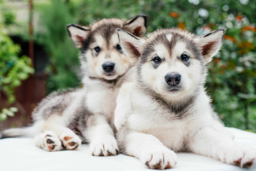

In [5]:
from fastdownload import download_url
dest = 'malamute.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256, 256)

Now we do the same with Huskies

Searching for 'husky photos'


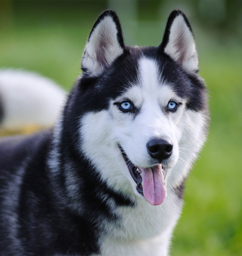

In [6]:
download_url(search_image('husky photos', max_images=1)[0], 'husky.jpg', show_progress=False)
Image.open('husky.jpg').to_thumb(256, 256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "husky" and "malamute" photos, and save each group of photos to a different folder (I'm also trying to search for photos of the dogs in different poses here):

In [7]:
searches = 'malamute', 'husky'
path = Path('malamute_or_husky')
from time import sleep

for i in searches:
    dest = (path/i)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_image(f'{i} photo)'))
    sleep(10) # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_image(f'{i} sitting photo'))
    sleep(10)
    download_images(dest, urls=search_image(f'{i} running photo'))
    sleep(10)
    resize_images(path/i, max_size=400, dest=path/i)

Searching for 'malamute photo)'
Searching for 'malamute sitting photo'
Searching for 'malamute running photo'
Searching for 'husky photo)'
Searching for 'husky sitting photo'
Searching for 'husky running photo'


## Step 2: Training Our Model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

9

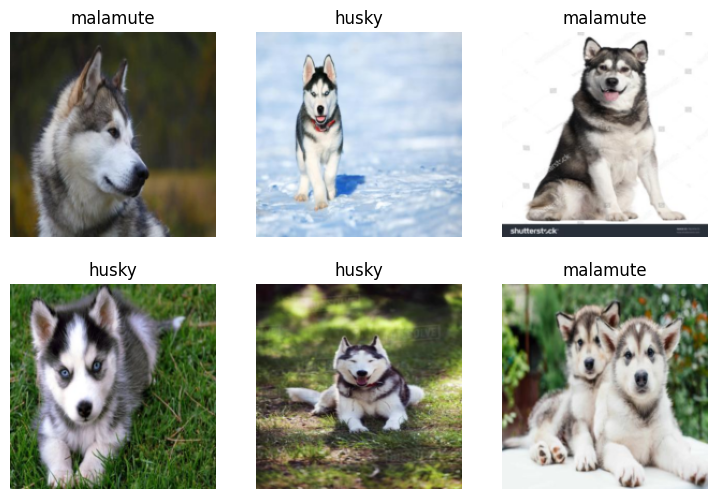

In [9]:
#Dataloaders containing training set and validation set
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [10]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 135MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.111371,1.011032,0.333333,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.686521,0.924663,0.393939,00:13
1,0.506118,0.954848,0.333333,00:13
2,0.376644,0.926175,0.333333,00:13


It seems like fine tuning resnet18 model yields an average error rate of about 20% thusfar. Considering the dataset is composed of random images with varying quality, I think such accuracy is quite decent for this simple model. Potential ways to improve the performance could include getting more data as well as data with better image quality. Other hyperparameters could also be tuned to optimize performance.

# Step 3: Use the Model

Let's see what our model thinks about the photos we downloaded at the start:

This is a: malamute.
Probability it's a malamute: 0.9991


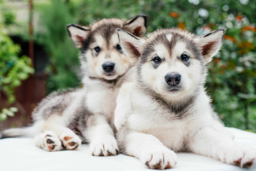

In [11]:
is_malamute,_,probs = learn.predict(PILImage.create('malamute.jpg'))
print(f"This is a: {is_malamute}.")
print(f"Probability it's a malamute: {probs[1]:.4f}")

Image.open('malamute.jpg').to_thumb(256,256)

This is a: husky.
Probability it's a malamute: 0.0282


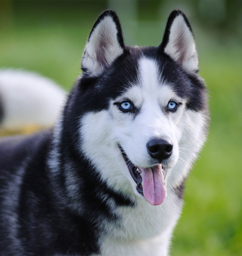

In [12]:
is_malamute,_,probs = learn.predict(PILImage.create('husky.jpg'))
print(f"This is a: {is_malamute}.")
print(f"Probability it's a malamute: {probs[1]:.4f}")

Image.open('husky.jpg').to_thumb(256,256)